In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    rec_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_rec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_rec = 1
        else:
            tmp_rec = len(set_true.intersection(set_pred))/\
                    float(len(set_true))
        rec_list.append(tmp_rec)
    return np.mean(rec_list)

def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
from csv import writer
import pandas as pd

def test_segment(filename, low, up):
    myFile = open(filename, 'w', newline = '')
    with myFile:
        csv_writer = writer(myFile)
        for j, row in enumerate(seqData):
            segment = [ ]
            if(len(row) > low and len(row) < up):
                segment.append(row)
                for item in label[j]:
                    segment.append(item)
                csv_writer.writerow(segment)
    myFile.close()

dataframe = pd.read_csv("/content/gdrive/My Drive/Multi-Attn/CAFA3/bp/test_data_bp1.csv", header=None)
dataset = dataframe.values
seqData = dataset[:,0]
label = dataset[:,1:len(dataset[0])]
print('Original Dataset Size : %s' %len(dataset))
test_segment('testData200.csv', 0, 201)
test_segment('testData500.csv', 200, 501)
test_segment('testData1000.csv', 500, 1001)
test_segment('testData16000.csv', 1000, 16000)

Original Dataset Size : 2392


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math

def segment(dataset, label, seg_size, overlap):
    print("Non-overlapping Region: %s" %overlap)
    print("Segment Size: %s" %seg_size)
  
    seq_data, label_data = [], []
    for j, row in enumerate(dataset):
        if(len(row) < 2001):
            pos = math.ceil(len(row)/overlap)
            if(pos < math.ceil(seg_size/overlap)):
                pos = math.ceil(seg_size/overlap)
            for itr in range(pos - math.ceil(seg_size/overlap) + 1):
                init = itr * overlap
                if(len(row[init : init + seg_size]) > 40):
                    seq_data.append(row[init : init + seg_size])
                    label_data.append(label[j])
    return seq_data, label_data

dataframe = pd.read_csv('/content/gdrive/My Drive/Multi-Attn/CAFA3/bp/train_data_bp1.csv', header=None)
dataset = dataframe.values
print('Original Dataset Size : %s' %len(dataset))
X = dataset[:,0]
Y = dataset[:,1:len(dataset[0])]
del dataframe, dataset
print(X.shape, Y.shape)

# Preparing For Training
segmentSize = 80
nonOL = 40
SEG = str(segmentSize)

X, Y = segment(X, Y, segmentSize, nonOL)
nb_of_cls = len(Y[0])

#Split the dataset
x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size = 0.1, random_state = 42)
del X, Y

y_train = np.array(y_tr, dtype=None)
y_validate = np.array(y_val, dtype=None)
print(len(x_tr), len(x_val))
print(y_train.shape, y_validate.shape)

del y_tr, y_val

Original Dataset Size : 53500
(53500,) (53500, 3992)
Non-overlapping Region: 40
Segment Size: 80
564680 62743
(564680, 3992) (62743, 3992)


In [ ]:
%tensorflow_version 1.x
import math
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, CuDNNGRU, Bidirectional, Input, Dropout, Add
from keras.layers import Flatten, Activation, RepeatVector, Permute, multiply, Lambda
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
np.random.seed(7)

def epsilon():
    _EPSILON = 1e-7
    return _EPSILON

def _to_tensor(x, dtype):
    return tf.convert_to_tensor(x, dtype=dtype)

def categorical_crossentropy(target, output, from_logits=False):
    if not from_logits:
        output /= tf.reduce_sum(output, len(output.get_shape()) - 1, True)      # scale preds so that the class probas of each sample sum to 1
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)               # manual computation of crossentropy
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output), len(output.get_shape()) - 1)
    else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=output)

def dictionary(chunk_size):
    dataframe = pd.read_csv("/content/gdrive/My Drive/Multi-Attn/CAFA3/bp/train_data_bp1.csv", header=None)
    dataset = dataframe.values
    del dataframe

    seq_dataset = dataset[:,0]
    print('Creating Dictionary:')
    dict = {}
    j = 0
    for row in seq_dataset:
        for i in range(len(row) - chunk_size + 1):
            key = row[i:i + chunk_size]
            if key not in dict:
                dict[key] = j
                j = j + 1
    del dataset, seq_dataset
    return(dict)

def nGram(dataset, chunk_size, dictI):
    dict1 = list()
    for j, row in enumerate(dataset):
        string = row
        dict2 = list()
        for i in range(len(string) - chunk_size + 1):
            try:
                dict2.append(dictI[string[i:i + chunk_size]])
            except:
                None
        dict1.append(dict2)   
    return(dict1)

# CREATING DICTIONARY
chunkSize = 4
dict_Prop = dictionary(chunkSize)
max_seq_len = segmentSize - chunkSize + 1

TensorFlow 1.x selected.


Using TensorFlow backend.


Creating Dictionary:


In [ ]:
def create_rec_model1(top_words, seq_len, o_dim):
    embedding_vecor_length = 32

    _input = Input(shape=[seq_len])
    embdd = Embedding(top_words, embedding_vecor_length, input_length = seq_len)(_input)
    drop1 = Dropout(0.4)(embdd)
    activations = Bidirectional(CuDNNGRU(200, return_sequences=True))(drop1)

    # compute importance for each step
    attention1 = Dense(1, activation='tanh')(activations)
    attention1 = Flatten()(attention1)
    attention1 = Activation('softmax')(attention1)
    
    attention2 = Dense(1, activation='tanh')(activations)
    attention2 = Flatten()(attention2)
    attention2 = Activation('softmax')(attention2)

    attention3 = Dense(1, activation='tanh')(activations)
    attention3 = Flatten()(attention3)
    attention3 = Activation('softmax')(attention3)

    attention4 = Dense(1, activation='tanh')(activations)
    attention4 = Flatten()(attention4)
    attention4 = Activation('softmax')(attention4)
    
    attention = Add()([attention1,attention2,attention3,attention4])
    attention = RepeatVector(400)(attention)
    attention = Permute([2, 1])(attention)
    
    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    drop2 = Dropout(0.5)(sent_representation)

    den1 = Dense(o_dim, kernel_initializer='normal', activation='softmax', name='RANKING')(drop2)
    den2 = Dense(o_dim, kernel_initializer='normal', activation='sigmoid', name='CLASSIFIER')(drop2)

    r_model = Model(inputs = [_input], outputs = [den1,den2])
    r_model.compile(loss=[categorical_crossentropy,'binary_crossentropy'], loss_weights=[0.30, 1.0],
                    optimizer='adam', metrics=['accuracy'])
    return r_model

#CREATING N-GRAM
x_train = nGram(x_tr, chunkSize, dict_Prop)
x_validate = nGram(x_val, chunkSize, dict_Prop)
del x_tr, x_val

# truncate and pad input sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_seq_len)
x_validate = sequence.pad_sequences(x_validate, maxlen=max_seq_len)

# Create & Compile the model
model = create_rec_model1(len(dict_Prop), max_seq_len, nb_of_cls)
print(model.summary())
early_stopping_monitor1 = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
history = model.fit(x_train, [y_train, y_train],
          validation_data = (x_validate, [y_validate, y_validate]),
          epochs = 1000,
          batch_size = 150,
          callbacks=[early_stopping_monitor1],
          verbose=1)

del y_train, y_validate

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 77)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 77, 32)       5151776     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 77, 32)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 

In [ ]:
from keras.models import load_model

def cls_predict(pred, normalize=True, sample_weight=None):
    pred1 = pred[0]
    pred2 = pred[1]
    y_pred1 = (pred2)**(1-pred1)
    y_pred2 = (pred1)**(1-pred2)
    y_pred = y_pred1 + y_pred2
    s_mean = np.mean(y_pred, axis=0)
    m = max(s_mean)
    s_mean = (s_mean/m)
    return(list(s_mean))

def final_model(filename):
    print('Extracting features based on LSTM model...... ')
    dataframe2 = pd.read_csv(filename, header=None)
    dataset2 = dataframe2.values
    overlap = 30
    X_test = dataset2[:,0]
    Y_test = dataset2[:,1:len(dataset2[0])]
    c_p = []
    for tag, row in enumerate(X_test):
        pos = math.ceil(len(row) / overlap)
        if(pos < math.ceil(segmentSize/ overlap)):
            pos = math.ceil(segmentSize/ overlap)
        segment = [ ]
        for itr in range(pos - math.ceil(segmentSize/overlap) + 1):
            init = itr * overlap
            segment.append(row[init : init + segmentSize])
        seg_nGram = nGram(segment, chunkSize, dict_Prop)
        test_seg = sequence.pad_sequences(seg_nGram, maxlen=max_seq_len)
        preds = model.predict(test_seg)
        c_p.append(cls_predict(preds))
    c_p = np.array(c_p)
    return c_p, Y_test

def create_nn_model(dim):
    n_model = Sequential()
    n_model.add(Dense(dim, input_dim = dim, kernel_initializer='normal', activation='relu'))
    n_model.add(Dense(dim, kernel_initializer='normal', activation='sigmoid'))
    n_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return n_model

# Creates a HDF5 file 'my_model.h5'
model_path = '/content/gdrive/My Drive/Multi-Attn/CAFA3/bp/simple+rank/0.3(4L)/32.200.model_'+str(nonOL)+'_'+ SEG +'.h5'
model.save(model_path)
#del model  
#model = load_model(model_path, custom_objects={'categorical_crossentropy': categorical_crossentropy})

# Training
X_train_new, Y_train_new = final_model("/content/gdrive/My Drive/Multi-Attn/CAFA3/bp/train_data_bp1.csv")

# Training model 2
model1 = create_nn_model(Y_train_new[0].shape[0])
print(model1.summary())
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
model1.fit(X_train_new, Y_train_new.astype(None),
           callbacks = [early_stopping_monitor],
           validation_split = 0.1,
           epochs = 1000,
           batch_size = 150,
           verbose = True)

Extracting features based on LSTM model...... 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3992)              15940056  
_________________________________________________________________
dense_6 (Dense)              (None, 3992)              15940056  
Total params: 31,880,112
Trainable params: 31,880,112
Non-trainable params: 0
_________________________________________________________________
None
Train on 48150 samples, validate on 5350 samples
Epoch 1/1000
48150/48150 [==============================] - 12s 258us/step - loss: 0.0424 - accuracy: 0.9885 - val_loss: 0.0246 - val_accuracy: 0.9924
Epoch 2/1000
48150/48150 [==============================] - 12s 254us/step - loss: 0.0245 - accuracy: 0.9922 - val_loss: 0.0229 - val_accuracy: 0.9927
Epoch 3/1000
48150/48150 [==============================] - 12s 254us/step - loss: 0.0232 - accuracy:

In [ ]:
#pip install 'h5py==2.10.0' --force-reinstall

Extracting features based on LSTM model...... 
(2392, 3992) (2392, 3992)
THRESHOLD IS =====>  0.01
Recall: 82.86543082114527      Precision: 10.945004339763981      F1-score1: 19.336068495965737       F1-score2: 17.77630740017112
THRESHOLD IS =====>  0.02
Recall: 78.30901411647088      Precision: 15.353016761177313      F1-score1: 25.6727212727642       F1-score2: 23.391854640233632
THRESHOLD IS =====>  0.03
Recall: 75.25035767724027      Precision: 18.65183877730619      F1-score1: 29.894030008337563       F1-score2: 27.126199043744986
THRESHOLD IS =====>  0.04
Recall: 73.03494525525002      Precision: 21.36742116418046      F1-score1: 33.062061771591026       F1-score2: 29.931758144284558
THRESHOLD IS =====>  0.05
Recall: 71.1791348027269      Precision: 23.677080011207977      F1-score1: 35.534078039241805       F1-score2: 32.079477298004235
THRESHOLD IS =====>  0.06
Recall: 69.5464231465817      Precision: 25.743833485703245      F1-score1: 37.577641204615276       F1-score2: 33.84

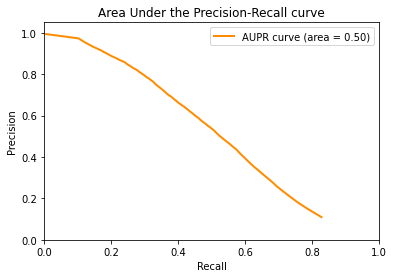

In [ ]:
from matplotlib import pyplot as plt

# Testing
def test_fun(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    Y_test_new = np.array(Y_test_new).astype(None)

    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = model1.predict(X_test_new)

        threshold = t / 100.0
        print("THRESHOLD IS =====> ", threshold)
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)

        rec = recall(Y_test_new, test_preds)
        pre = precision(Y_test_new, test_preds)
        recalls.append(rec)
        precisions.append(pre)

        f1 = f_score(Y_test_new, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax

th_set = test_fun("/content/gdrive/My Drive/Multi-Attn/CAFA3/bp/test_data_bp1.csv")

In [ ]:
# Testing
def test_fun1(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    test_preds = model1.predict(X_test_new)
    Y_test_new = np.array(Y_test_new).astype(None)
    test_preds[test_preds>=th_set] = int(1)
    test_preds[test_preds<th_set] = int(0)
    rec = recall(Y_test_new, test_preds)*100
    pre = precision(Y_test_new, test_preds)*100
    f1 = f_score(Y_test_new, test_preds)*100
    print('      Recall: {0}'.format(rec),  '       Precision: {0}'.format(pre),  '       F1-score: {0}'.format(f1))

test_fun1("testData200.csv")
test_fun1("testData500.csv")
test_fun1("testData1000.csv")
test_fun1("testData16000.csv")

Extracting features based on LSTM model...... 
(334, 3992) (334, 3992)
      Recall: 39.99452083004831        Precision: 37.997636740357386        F1-score: 31.67493222735473
Extracting features based on LSTM model...... 
(1315, 3992) (1315, 3992)
      Recall: 54.81165788030155        Precision: 58.30189660518129        F1-score: 50.08498693095653
Extracting features based on LSTM model...... 
(540, 3992) (540, 3992)
      Recall: 46.60144450416361        Precision: 55.90681932103535        F1-score: 42.779240125570645
Extracting features based on LSTM model...... 
(203, 3992) (203, 3992)
      Recall: 38.222660745033764        Precision: 52.569491675124965        F1-score: 34.27501365124864
